In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import csv

In [ ]:
from zipfile import ZipFile

In [ ]:
#with ZipFile('/content/drive/MyDrive/Colab Notebooks/images.zip', 'r') as z:
 # z.extractall()

In [ ]:
dataset_folder= "./images"
train_csv= '/content/drive/MyDrive/Colab Notebooks/train.csv'
validation_csv= '/content/drive/MyDrive/Colab Notebooks/validation.csv'

In [ ]:
# get training data
image_size= 128

In [ ]:
with open(train_csv,'r') as f:
  y_train= np.zeros((sum(1 for line in f), 4))
  x_train= []
  f.seek(0)
  data= csv.reader(f, delimiter=',')
  for index,row in enumerate(data):
    for i,r in enumerate(row[1:7]):
      row[i+1]= int(r)
    path,image_ht,image_w,x0,y0,x1,y1,__,_= row
    path= "./"+ path.split('/')[-2]+"/"+path.split('/')[-1]
    y_train[index, 0]= x0*image_size/ image_w # normalizting the bounding box
    y_train[index, 1]= y0*image_size/ image_ht
    y_train[index, 2]= (x1-x0)*image_size/ image_w
    y_train[index, 3]= (y1-y0)*image_size/ image_w
    x_train.append(path) # all the training images are here in the list

In [ ]:
x_train[:5]

['./images/Abyssinian_1.jpg',
 './images/Abyssinian_10.jpg',
 './images/Abyssinian_100.jpg',
 './images/Abyssinian_101.jpg',
 './images/Abyssinian_102.jpg']

In [ ]:
import cv2

In [ ]:
filename= x_train[97]
im= cv2.imread(filename)


In [ ]:
region= y_train[97]
image_ht, image_w,_ = im.shape

In [ ]:
# ploting the box around image
x0= int(region[0]* image_w/image_size)
y0= int(region[1]* image_ht/image_size)
x1= int((region[0]+region[2])* image_w/image_size)
y1= int((region[1]+region[3])* image_ht/image_size)

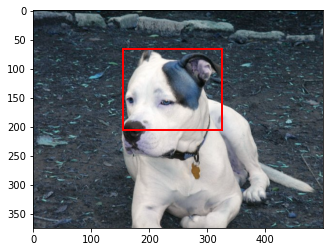

In [ ]:
# plot
import matplotlib.pyplot as plt
import matplotlib.patches as pat
fig, ax= plt.subplots(1)
ax.imshow(im)
rect= pat.Rectangle((x0,y0), x1-x0, y1-y0, linewidth=2, edgecolor='r', facecolor= 'none')
ax.add_patch(rect)
plt.show()

<h4>1st boundery box function did look well 
<br>So we will redo the function
<br>2nd result is a little better
</h4>

<h1>above is done with pure python </h1>

In [ ]:
# we will try with the help of building architecture(neural network)
from tensorflow.keras.applications.mobilenet import MobileNet
import tensorflow

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape

In [ ]:
ALPHA= 1.0 # its a variable we used to define the width 

In [ ]:
with open(validation_csv,"r") as f:
  y_val=np.zeros((sum(1 for line in f),4))
  x_val=[]
  f.seek(0)
  data=csv.reader(f,delimiter=',')
  for index,row in enumerate(data):
    for i,r in enumerate(row[1:7]):
      row[i+1]=int(r)
    path, image_ht, image_w, x0, y0, x1, y1,_,_= row
    path="./"+path.split('/')[-2]+"/"+path.split('/')[-1]
    y_val[index,0]= x0*image_size / image_w #normalize bounding box
    y_val[index,1]= y0*image_size/image_ht
    y_val[index,2]= (x1-x0)*image_size/image_w
    y_val[index,3]= (y1-y0)*image_size/image_ht
    x_val.append(path) #all training images are in the list

In [ ]:
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input

In [ ]:
# preprocessing the images
for i,f in enumerate(x_train):
  img= Image.open(f)
  img= img.resize((image_size, image_size))
  img= img.convert ('RGB')
  x_train[i]= preprocess_input(np.array(img, dtype= np.float32))
  img.close()
x_train= np.array(x_train)

In [ ]:
for i,f in enumerate(x_val):
  img= Image.open(f)
  img= img.resize((image_size, image_size))
  img= img.convert ('RGB')
  x_val[i]= preprocess_input(np.array(img, dtype= np.float32))
  img.close()

In [ ]:
x_val= np.array(x_val)

In [ ]:
"""def create_model (trainable= True):
  model= MobileNet(input_shape=(image_size, image_size, 3),include_top= False, alpha= ALPHA)
  for layer in model.layers:
    layer.trainable= trainable
  x0= model.layers[-1].output 
  x1= Conv2D(4, kernal_size= 4, name='coords')(x0) 
  x2= Reshape((4, ))(x1)
  return Model(inputs= model.input, outputs= x2)"""

"def create_model (trainable= True):\n  model= MobileNet(input_shape=(image_size, image_size, 3),include_top= False, alpha= ALPHA)\n  for layer in model.layers:\n    layer.trainable= trainable\n  x0= model.layers[-1].output \n  x1= Conv2D(4, kernal_size= 4, name='coords')(x0) \n  x2= Reshape((4, ))(x1)\n  return Model(inputs= model.input, outputs= x2)"

In [ ]:
def create_model(trainable=True):
  model=MobileNet(input_shape=(image_size, image_size, 3), include_top=False, alpha=ALPHA)
  for layer in model.layers:
    layer.trainable=trainable
  x0=model.layers[-1].output #last layer of image will be output layer
  x1=Conv2D(4, kernel_size=4, name="coords")(x0) # creating convolution nn # at output we need 4 output kernal size as 4 and name of output is gien as coords
  x2=Reshape((4, ))(x1)
  return Model(inputs=model.input, outputs=x2)

In [ ]:
# defining IOU
def IOU(y_true, y_pred):
  intersections= 0
  unions= 0
  gt= y_true #gt = ground truth
  pred= y_pred
  #computing intersection og pred and gt bounding box
  diff_width= np.minimum(gt[:, 0]+ gt[:, 2], pred[:, 0]+ pred[:, 2])-np.maximum(gt[:, 0], pred[:, 0])
  diff_ht= np.minimum(gt[:, 1]+ gt[:, 3], pred[:, 1]+ pred[:, 3])- np.maximum(gt[:, 1], pred[:, 1])
  intersection= diff_ht*diff_width
  # compute unio
  area_gt= gt[:, 2]*gt[:, 3]
  area_pred= pred[:, 2]*pred[:, 3]
  union= area_gt+area_pred-intersection
  # compute intersection and union over multiple boxes
  for j,p in enumerate(union):
      if(union[j]>0 and intersection[j]>0 and union[j]>=intersection[j]):
        intersections=intersections+intersection[j]
        unions=unions+union[j]
  #compute IOU
  iou=np.round(intersections/(unions+ tensorflow.keras.backend.epsilon()),4)
  iou=iou.astype(np.float32)
  return iou

In [ ]:
"""def IOU(y_true,y_pred):
  intersections=0
  unions=0
  gt=y_true
  pred=y_pred
  #compute interscction of predicted (pred) and ground truth(gt) bounding box
  diff_width=np.minimum(gt[:,0]+gt[:,2],pred[:,0]+pred[:,2])-np.maximum(gt[:,0],pred[:,0])
  diff_ht=np.minimum(gt[:,1]+gt[:,3],pred[:,1]+pred[:,3])-np.maximum(gt[:,1],pred[:,1])
  intersection=diff_width*diff_ht
  #compute union
  area_gt=gt[:,2]*gt[:,3]
  area_pred=pred[:,2]*pred[:,3]
  union=area_gt+area_pred-intersection
  #compute intersection and union over multiple boxes
  for j,p in enumerate(union):
    if(union[j]>0 and intersection[j]>0 and union[j]>=intersection[j]):
      intersections=intersections+intersection[j]
      unions=unions+union[j]
  #compute IOU
  iou=np.round(intersections/(unions+tensorflow.keras.backend.epsilon()),4)
  iou=iou.astype(np.float32)
  return iou"""

In [ ]:
# IOU ----- intersection over union we use to check how good an image model is built
# it check how deviavted is the box from original/needed
def intersection_over_union(y_true, y_pred):# it take actual value and predicted value
   iou= tf.py_function(IOU, [y_true, y_pred], Tout= tf.float32) # for better display of output we are mannual convetring eveything in float32 type
   return iou

In [ ]:
model= create_model()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                      

In [ ]:
# complie the model
model.compile(loss= 'mean_squared_error',optimizer= 'adam', metrics= [intersection_over_union])

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_intersection_over_union', patience=5, min_delta=0.01) # patience is iteration that is 5 continous iteration 
# mointor is based on what we want to have early stoppping
# val is the value we get of our user defined function

In [ ]:
model.fit(x_train, y_train, validation_data= (x_val, y_val), epochs=1, batch_size=32, callbacks=[callback])